<a href="https://colab.research.google.com/github/aghosh92/DKLActiveLearnMol/blob/main/Notebooks/notebookIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we explore how Deep Kernel Learning (DKL) can be applied to molecular dataset, or can be built as an active experiment where the features (molecular structures) are available all at the same time, and the targets are becoming available sequentially. It  provides a way to guide 'experimental' discovery, and also forms particularly well organized latent spaces.

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh (SMIILES to SELFIES part), research.aghosh@gmail.com
- The GPax is by Maxim Ziatdinov, https://github.com/ziatdinovmax/gpax
- The DKL is adapted from the notebooks from Mani Valleti, svalleti@vols.utk.edu
- Workflow built by Sergei V. Kalinin
- DKL for subsets of QM9 dataset adapted by Ayana Ghosh

In [1]:
# @title Install packages
!pip install wget
!pip install rdkit-pypi
!pip install selfies --upgrade
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the AtomAI VAE

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e620edbc9008306cae6e82f81d22d095e0260399860eedbdebac0bd53bef1330
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
# @title Import libraries
import wget
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import warnings

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch
import torch.nn as nn
tt = torch.tensor
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf
import gpax
import atomai as aoi

import jax.numpy as jnp
gpax.utils.enable_x64()

In [3]:
# @title Utility functions
def find_nearest_neighbors(reference_idx, embedding, num_neighbors=9):
    """Find the indices of the nearest neighbors to a reference point."""
    reference_point = embedding[reference_idx]
    distances = distance.cdist([reference_point], embedding, 'euclidean').flatten()
    nearest_indices = np.argsort(distances)[1:num_neighbors+1]  # Exclude the reference point itself
    warnings.filterwarnings("ignore", category=UserWarning)  # Ignore userwarnings
    return nearest_indices

def find_indices(original, search):
    indices = []
    for row in search:
        # Find the index of the row in the original array
        index = np.where((original == row).all(axis=1))[0]
        if index.size > 0:
            indices.append(index[0])
        else:
            indices.append(-1)  # -1 indicates not found
    return np.array(indices)

def are_points_separated(point, other_points, min_distance):
    """Check if 'point' is at least 'min_distance' away from all points in 'other_points'."""
    return np.all(np.linalg.norm(other_points - point, axis=1) >= min_distance)

Read in dataset (One of the subsets from QM9 containing 5,000 randomly selected molecules)

In [4]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset0_5k.csv?raw=true"
df = pd.read_csv(git_link, index_col=0)
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,...,stereocent,dipole_moment,enthalpy,internal_energy,internal_energy_zero,free_energy,homo,lumo,gap,zero_point_vib_energy
80704,OCC(C#C)C#CC#C,-0.13530,20.23,118.041865,1,1,"(44,)",0.104838,-0.394070,1,...,1,1.0110,-383.379422,-383.380366,-383.390139,-383.425247,-0.2487,-0.0227,0.2260,0.109023
65243,OC1C2NC1(C#C)C2O,-1.93440,52.49,125.047678,3,3,"(48,)",0.135711,-0.388302,0,...,2,2.9389,-437.764349,-437.765293,-437.773455,-437.805879,-0.2457,0.0183,0.2640,0.123328
127044,C1C2C3CC(CCO3)N12,0.23180,12.24,125.084064,0,2,"(50,)",0.075724,-0.376416,0,...,4,1.2046,-403.111686,-403.112630,-403.119162,-403.149575,-0.2233,0.0819,0.3052,0.175386
78132,CC1=CC2CC(O2)C1O,0.46470,29.46,126.068080,1,2,"(50,)",0.101096,-0.386045,0,...,3,2.0914,-423.006427,-423.007371,-423.015176,-423.047111,-0.2388,0.0018,0.2405,0.160473
90425,CC1CC1(O)CCC=O,0.73640,37.30,128.083730,1,2,"(52,)",0.119600,-0.389588,3,...,2,2.1074,-424.213274,-424.214219,-424.224729,-424.261135,-0.2481,-0.0208,0.2273,0.178994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117107,OC1C2C3NC3(C#N)C12,-1.15892,65.96,122.048013,2,3,"(46,)",0.128183,-0.392345,0,...,5,6.3772,-416.738039,-416.738983,-416.746403,-416.778259,-0.2729,0.0142,0.2871,0.113488
8240,NC(=O)C(=O)NCC=O,-2.21320,89.26,130.037842,2,3,"(50,)",0.308947,-0.361393,2,...,0,2.7234,-491.145917,-491.146862,-491.156301,-491.192146,-0.2543,-0.0462,0.2081,0.111181
82724,CC1C(C)N1CC1CO1,0.47780,15.54,127.099714,0,2,"(52,)",0.093621,-0.371734,2,...,3,2.2996,-404.281755,-404.282699,-404.292728,-404.328359,-0.2208,0.0761,0.2969,0.192277
33180,NC(=O)C1CC1CCO,-0.50980,63.32,129.078979,2,2,"(52,)",0.220321,-0.396365,3,...,2,3.7023,-440.294320,-440.295265,-440.305434,-440.341331,-0.2486,0.0246,0.2732,0.170268


Convert smiles to one-hot vectors

In [5]:
selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(row['smiles'])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

(5000, 567)


In [10]:
#Different targets
targets1 = df['ringct'].values
targets2 = df['mole_logp'].values
targets3 = df['mol_wt'].values
targets4 = df['dipole_moment'].values

For illustration purpose, we show the training on 1,000 molecules since training on a higher number of molecules may take longer & more computing resources.

In [11]:
X1 = np.copy(X)
X1 = X1[:1000]
targets1 = targets1[:1000]

#Train the DKL model
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)

100%|██████████| 1000/1000 [07:25<00:00,  2.24it/s, init loss: 41045.4279, avg. loss [951-1000]: 36806.3720]



Inferred GP kernel parameters
k_length         [1.4378 1.226 ]
k_scale          5.5997
noise            0.0154


In [13]:
batch_size_reconstruct = 250

embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

## Active learning

In [7]:
X1 = np.copy(X)
X1 = X1[:1000]
#target
targets1 = - df['enthalpy'].values
targets1 = targets1[:1000]

For illustration purpose, we show the training on 1,000 molecules with 30 exploration steps since training on a higher number of molecules may take longer & more computing resources.

In [8]:
#Active learning setup parameters
init_num = 50
exp_step = 30
batch_size_learn = 50 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

In [9]:
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]
y1_train = targets1[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

In [14]:
exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(s2*s3, 2, 'RBF')
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_1.predict_in_batches(#make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])

    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])

    # Perform evaluation
    y_measured = targets1[ind_next]

    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)

    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=batch_size_learn)

    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)
    traj_std1.append(traj_s)


Step 1


100%|██████████| 1000/1000 [00:06<00:00, 152.24it/s, init loss: 1217497.7502, avg. loss [951-1000]: 55812.8172]



Inferred GP kernel parameters
k_length         [1.411  0.9729]
k_scale          6.2382
noise            2.3288

Step 2


100%|██████████| 1000/1000 [00:06<00:00, 152.44it/s, init loss: 1221940.9292, avg. loss [951-1000]: 59416.2185]



Inferred GP kernel parameters
k_length         [1.3223 0.9056]
k_scale          6.8058000000000005
noise            4.6238

Step 3


100%|██████████| 1000/1000 [00:06<00:00, 155.69it/s, init loss: 1231605.7610, avg. loss [951-1000]: 59382.9406]



Inferred GP kernel parameters
k_length         [1.3327 0.9153]
k_scale          6.8495
noise            4.5263

Step 4


100%|██████████| 1000/1000 [00:06<00:00, 152.91it/s, init loss: 1275972.4800, avg. loss [951-1000]: 59722.9372]



Inferred GP kernel parameters
k_length         [1.3473 0.9072]
k_scale          6.849
noise            4.143800000000001

Step 5


100%|██████████| 1000/1000 [00:05<00:00, 173.30it/s, init loss: 1305640.8154, avg. loss [951-1000]: 59925.8727]



Inferred GP kernel parameters
k_length         [1.3529 0.9036]
k_scale          6.8574
noise            3.9362000000000004

Step 6


100%|██████████| 1000/1000 [00:05<00:00, 173.79it/s, init loss: 1334855.9867, avg. loss [951-1000]: 60086.3506]



Inferred GP kernel parameters
k_length         [1.3702 0.9574]
k_scale          6.9686
noise            3.5547

Step 7


100%|██████████| 1000/1000 [00:05<00:00, 181.05it/s, init loss: 1361538.7316, avg. loss [951-1000]: 60247.8410]



Inferred GP kernel parameters
k_length         [1.3699 0.9171]
k_scale          6.9451
noise            3.4063000000000003

Step 8


100%|██████████| 1000/1000 [00:04<00:00, 209.46it/s, init loss: 1391660.6513, avg. loss [951-1000]: 60954.6797]



Inferred GP kernel parameters
k_length         [1.3761 0.964 ]
k_scale          6.7262
noise            3.325

Step 9


100%|██████████| 1000/1000 [00:05<00:00, 188.48it/s, init loss: 1413044.0793, avg. loss [951-1000]: 64734.3646]



Inferred GP kernel parameters
k_length         [1.3822 0.9336]
k_scale          5.528300000000001
noise            3.5018000000000002

Step 10


100%|██████████| 1000/1000 [00:05<00:00, 177.74it/s, init loss: 1429456.6399, avg. loss [951-1000]: 70282.0795]



Inferred GP kernel parameters
k_length         [1.404  0.9673]
k_scale          7.7426
noise            3.5336000000000003

Step 11


100%|██████████| 1000/1000 [00:05<00:00, 190.59it/s, init loss: 1450607.7240, avg. loss [951-1000]: 69190.7716]



Inferred GP kernel parameters
k_length         [1.3667 0.9442]
k_scale          8.0876
noise            3.3916

Step 12


100%|██████████| 1000/1000 [00:05<00:00, 177.86it/s, init loss: 1465877.2342, avg. loss [951-1000]: 64363.9385]



Inferred GP kernel parameters
k_length         [1.3782 1.0246]
k_scale          5.7328
noise            3.1891000000000003

Step 13


100%|██████████| 1000/1000 [00:06<00:00, 148.66it/s, init loss: 1478197.4492, avg. loss [951-1000]: 56110.9306]



Inferred GP kernel parameters
k_length         [1.4392 1.1946]
k_scale          6.0936
noise            2.3194

Step 14


100%|██████████| 1000/1000 [00:13<00:00, 75.33it/s, init loss: 1492349.4504, avg. loss [951-1000]: 73355.7815]



Inferred GP kernel parameters
k_length         [1.3901 0.9457]
k_scale          6.992
noise            3.4955000000000003

Step 15


100%|██████████| 1000/1000 [00:05<00:00, 187.26it/s, init loss: 1513718.7185, avg. loss [951-1000]: 72311.5939]



Inferred GP kernel parameters
k_length         [1.4159 0.9608]
k_scale          7.1404000000000005
noise            3.7219

Step 16


100%|██████████| 1000/1000 [00:05<00:00, 191.34it/s, init loss: 1531867.9835, avg. loss [951-1000]: 70457.4497]



Inferred GP kernel parameters
k_length         [1.4302 0.944 ]
k_scale          7.531700000000001
noise            3.8313

Step 17


100%|██████████| 1000/1000 [00:06<00:00, 153.11it/s, init loss: 1543293.7244, avg. loss [951-1000]: 72926.1564]



Inferred GP kernel parameters
k_length         [1.4192 0.977 ]
k_scale          6.9848
noise            3.6739

Step 18


100%|██████████| 1000/1000 [00:07<00:00, 137.00it/s, init loss: 1559870.6114, avg. loss [951-1000]: 79496.6455]



Inferred GP kernel parameters
k_length         [1.3486 0.9376]
k_scale          8.2546
noise            3.9295

Step 19


100%|██████████| 1000/1000 [00:06<00:00, 165.38it/s, init loss: 1590903.1282, avg. loss [951-1000]: 78387.2586]



Inferred GP kernel parameters
k_length         [1.4178 0.9852]
k_scale          8.5539
noise            3.7819000000000003

Step 20


100%|██████████| 1000/1000 [00:06<00:00, 166.54it/s, init loss: 1612881.2863, avg. loss [951-1000]: 74275.0697]



Inferred GP kernel parameters
k_length         [1.469  0.9659]
k_scale          6.9687
noise            3.1790000000000003

Step 21


100%|██████████| 1000/1000 [00:05<00:00, 175.10it/s, init loss: 1640908.3176, avg. loss [951-1000]: 74652.2888]



Inferred GP kernel parameters
k_length         [1.4801 1.0131]
k_scale          6.9173
noise            3.0673000000000004

Step 22


100%|██████████| 1000/1000 [00:05<00:00, 177.33it/s, init loss: 1660789.3450, avg. loss [951-1000]: 86860.0535]



Inferred GP kernel parameters
k_length         [1.3643 0.9506]
k_scale          8.773
noise            4.3145

Step 23


100%|██████████| 1000/1000 [00:07<00:00, 135.28it/s, init loss: 1677959.5865, avg. loss [951-1000]: 84518.8098]



Inferred GP kernel parameters
k_length         [1.3512 0.9764]
k_scale          8.2521
noise            3.8461000000000003

Step 24


100%|██████████| 1000/1000 [00:07<00:00, 138.18it/s, init loss: 1679059.7429, avg. loss [951-1000]: 82892.6324]



Inferred GP kernel parameters
k_length         [1.3383 1.0101]
k_scale          7.5848
noise            3.7293000000000003

Step 25


100%|██████████| 1000/1000 [00:06<00:00, 159.01it/s, init loss: 1698729.9605, avg. loss [951-1000]: 91161.6118]



Inferred GP kernel parameters
k_length         [1.2834 0.9611]
k_scale          7.8032
noise            4.7654000000000005

Step 26


100%|██████████| 1000/1000 [00:07<00:00, 141.81it/s, init loss: 1716643.5959, avg. loss [951-1000]: 84939.9733]



Inferred GP kernel parameters
k_length         [1.4048 0.9804]
k_scale          8.206
noise            3.7409000000000003

Step 27


100%|██████████| 1000/1000 [00:06<00:00, 151.28it/s, init loss: 1731613.4643, avg. loss [951-1000]: 76182.3384]



Inferred GP kernel parameters
k_length         [1.7578 1.1253]
k_scale          5.735
noise            2.4098

Step 28


100%|██████████| 1000/1000 [00:08<00:00, 113.95it/s, init loss: 1743030.5515, avg. loss [951-1000]: 92970.9192]



Inferred GP kernel parameters
k_length         [1.3652 0.939 ]
k_scale          8.4422
noise            4.1363

Step 29


100%|██████████| 1000/1000 [00:11<00:00, 90.16it/s, init loss: 1761715.9432, avg. loss [951-1000]: 91447.7626]



Inferred GP kernel parameters
k_length         [1.3826 0.8938]
k_scale          7.944400000000001
noise            4.1627

Step 30


100%|██████████| 1000/1000 [00:09<00:00, 102.05it/s, init loss: 1767944.4186, avg. loss [951-1000]: 93079.2001]



Inferred GP kernel parameters
k_length         [1.429  0.9218]
k_scale          7.5804
noise            4.4655000000000005


In [15]:
#prediction
rng_key11, rng_key_predict11 = gpax.utils.get_keys()
dkl_BO_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_BO_1.fit(rng_key11, X1_train, y1_train)

predmean_train1, predstd_train1 = dkl_BO_1.predict_in_batches(rng_key_predict11,
                                                              X1_train, batch_size=batch_size_learn)
predmean_unmeas1, predstd_unmeas1 = dkl_BO_1.predict_in_batches(rng_key_predict11,
                                                                X1_unmeasured, batch_size=batch_size_reconstruct)
predmean11, predstd11 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1,
                                                    batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:13<00:00, 72.19it/s, init loss: 1772005.2786, avg. loss [951-1000]: 86401.4938]



Inferred GP kernel parameters
k_length         [1.3408 0.9666]
k_scale          7.7564
noise            4.2484


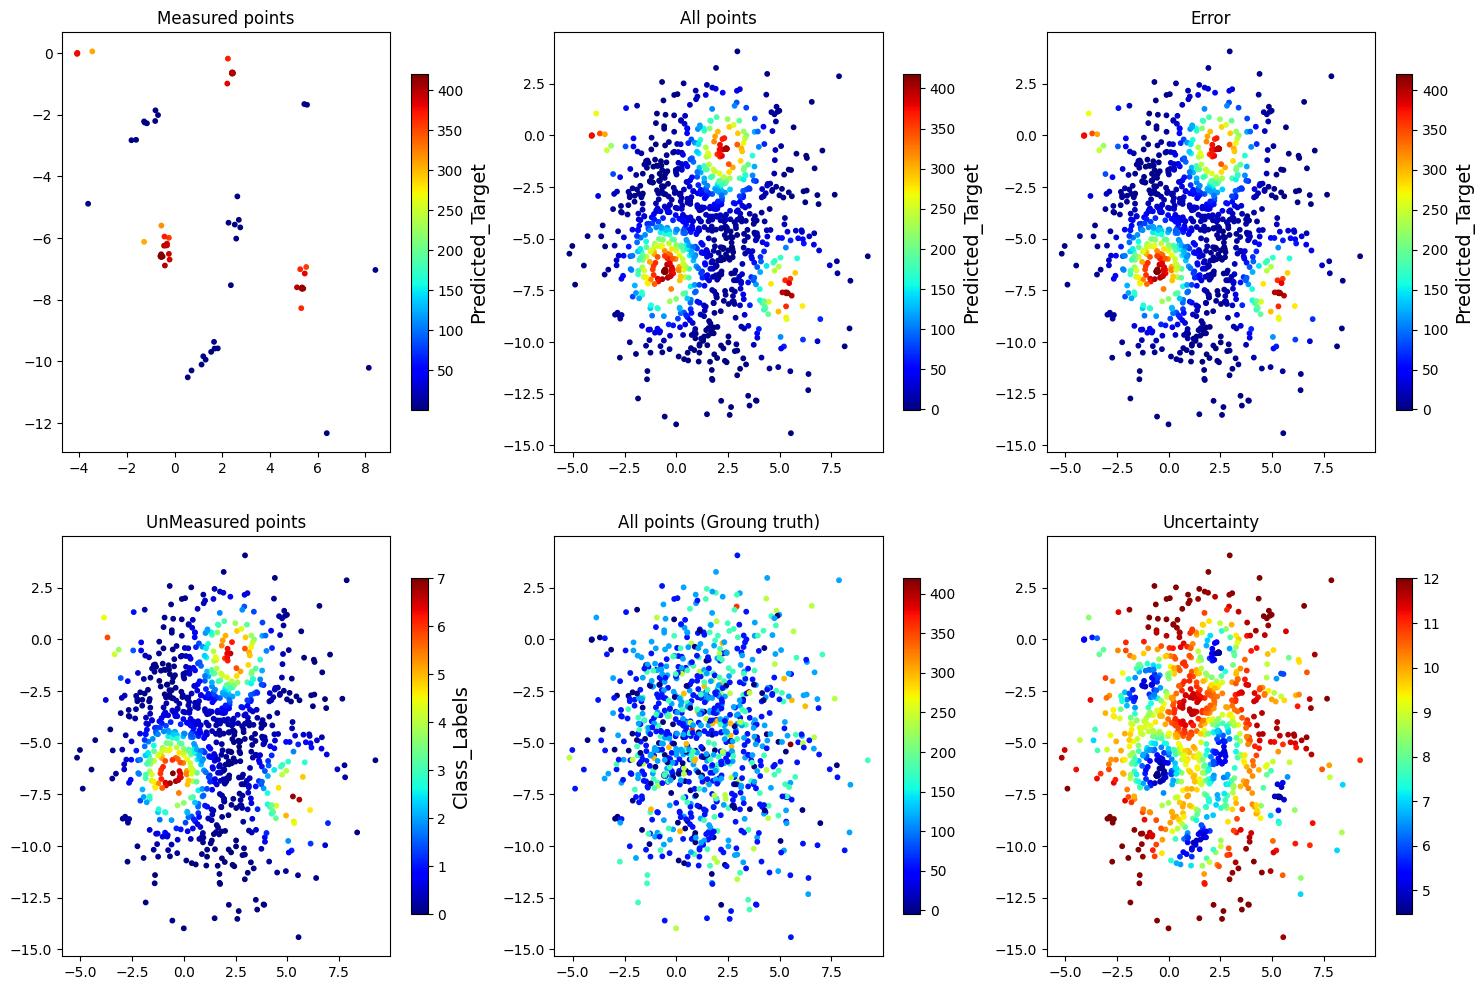

In [17]:
embeded_train1 = dkl_BO_1.embed(X1_train)  # Measured points
embeded_unmeasured1 = dkl_BO_1.embed(X1_unmeasured)  # Unmeasured points
embeded11 = dkl_BO_1.embed(X1)   # All points

#visualize the latent space
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train1[:, 1], embeded_train1[:, 0], s=10, c = predmean_train1, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_unmeasured1[:, 1], embeded_unmeasured1[:, 0], s=10,
                c = predmean_unmeas1, cmap = 'jet')
ax[1,0].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11, cmap = 'jet')
ax[0,1].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = targets1, cmap = 'jet')
ax[1,1].set_title('All points (Groung truth)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11 - targets1, cmap = 'jet')
ax[0,2].set_title('Error')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
#cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predstd11, cmap = 'jet')
ax[1,2].set_title('Uncertainty')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
#cbar.set_label("Wt", fontsize=14)
cbar.ax.tick_params(labelsize=10)